# **2.1 Data Loading**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Setting up transformations for images
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
# Loading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1024,
                                          shuffle=True)

# Loading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024,
                                         shuffle=False)

# Class names in CIFAR10 (Labels)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

x_train,y_train = train_data.data, train_data.targets
x_test,y_test = test_data.data, test_data.targets

y_train = np.array(y_train)
y_test = np.array(y_test)

Files already downloaded and verified
Files already downloaded and verified


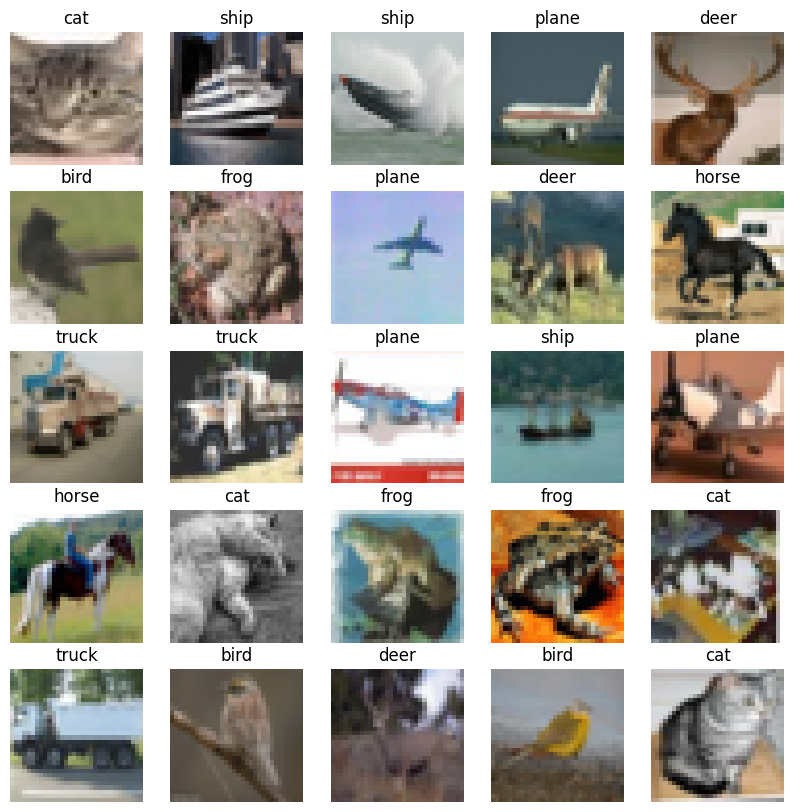

In [6]:
# Plotting n random images from the dataset
def plot_random_images(n, x_data, y_data, classes):
    indices = np.random.randint(0, len(x_data), size=n)
    images = x_data[indices]
    labels = np.array(y_data)[indices]

    plt.figure(figsize=(10,10))
    for i in range(len(indices)):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

plot_random_images(25, x_train, y_train, classes)

# **Brief Discussion**

**I would say it may find difficulty in distinguishing 1. horses from deers, 2. trucks from cars, and 3. possibly "flying" birds from planes because these pairs are somewhat similar.**

# **2.2 Model Definition**

In [11]:
class MLP(nn.Module):
    def __init__(self, layers: []): # layers is a list of integers that define the number of the linear layers and their dimensions
        super(MLP, self).__init__()
        self.layers = nn.Sequential() # A sequential contained to hold the layers
        self.flatten = nn.Flatten()
        # Looping through the list of layer sizes to create linear layers.
        # Each layer's input and output size are determined by every two consecutive pairs in the layers list.
        
        for i in range(len(layers) - 1):
            self.layers.add_module(str(i*2), nn.Linear(layers[i], layers[i+1]))
            i = i + 1
            if i < len(layers) - 1:  # Add ReLU for all layers except the last one layer
                self.layers.add_module(str(2*i-1), nn.ReLU())
                
    def forward(self, x):
        x = self.flatten(x)  # Flatten the input tensor to fit the size of the first layer
        
        # The output of each layer is then passed as an input to the next layer.
        return self.layers(x)

model = MLP([784,256,128,10])
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


# **2.3 Model Training and Testing**

In [12]:
# Same as Lab2

def train_model(model, inputs, labels, optimizer): 
    model.train()
    loss = nn.CrossEntropyLoss() # Loss function
    optimizer.zero_grad()
    predictions = model(inputs)
    lss = loss(predictions, labels)
    lss.backward()
    optimizer.step()
    return lss.item(), np.mean((predictions.argmax(axis= 1) == labels).numpy())

def validate_model(model, inputs, labels):
    with torch.no_grad():
        model.eval()
        loss = nn.CrossEntropyLoss()
        predictions = model(inputs)
        lss = loss(predictions,labels)
    return lss.item(), np.mean((predictions.argmax(axis= 1) == labels).numpy())

In [16]:
# Initialize the model and train
model = MLP([3072, 1024, 256, 128, 10]) # CIFAR10 images are 3x32x32, so 3072 input features
n_epochs = 50
# Same as Lab2, but I do it once for every batch
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0005
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for e in range(n_epochs):
    training_lss_history = []
    training_acc_history=[]
    test_lss_history = []
    test_acc_history=[]
    for data, data_test in zip(train_loader, test_loader):
            inputs, labels = data
            inputs_test, labels_test = data_test
            lss,acc= train_model(model,inputs,labels, optimizer)
            test_lss,test_acc= validate_model(model,inputs_test,labels_test)
            training_acc_history.append(acc)
            test_acc_history.append(test_acc)
            training_lss_history.append(lss)
            test_lss_history.append(test_lss)
    print(f"For epoch {e:3d} || Training Loss {np.mean(training_lss_history):5.3f} || Train acc {np.mean(training_acc_history):5.3f}", end='')
    print(f" || Testing Loss {np.mean(test_lss_history):5.3f} || Test acc {np.mean(test_acc_history):5.3f}")
    
    # These accuracies are for learning rate = 0.001, batch size = 1024, and only 50 epochs.
    # It already meets the 55% threshold (well, 54.5%, so...), so I will not try the other measures for now.
    # The assignment already took SO LONG from me.
    # I have another version of the assignment that didn't work for me. It has "better" code but for some reason it doesn't work.
    # This code is a bit dirty and from all over the place, but I think it does the job.

For epoch   0 || Training Loss 2.031 || Train acc 0.265 || Testing Loss 1.985 || Test acc 0.289
For epoch   1 || Training Loss 1.791 || Train acc 0.364 || Testing Loss 1.768 || Test acc 0.372
For epoch   2 || Training Loss 1.683 || Train acc 0.402 || Testing Loss 1.668 || Test acc 0.404
For epoch   3 || Training Loss 1.615 || Train acc 0.432 || Testing Loss 1.611 || Test acc 0.427
For epoch   4 || Training Loss 1.546 || Train acc 0.455 || Testing Loss 1.579 || Test acc 0.448
For epoch   5 || Training Loss 1.528 || Train acc 0.463 || Testing Loss 1.538 || Test acc 0.460
For epoch   6 || Training Loss 1.479 || Train acc 0.474 || Testing Loss 1.518 || Test acc 0.465
For epoch   7 || Training Loss 1.468 || Train acc 0.478 || Testing Loss 1.500 || Test acc 0.468
For epoch   8 || Training Loss 1.422 || Train acc 0.506 || Testing Loss 1.473 || Test acc 0.480
For epoch   9 || Training Loss 1.407 || Train acc 0.505 || Testing Loss 1.446 || Test acc 0.488
For epoch  10 || Training Loss 1.384 || 

# **2.4 Plotting**

In [17]:
def visualize_predictions(model, test_loader, n_images):
    model.eval()
    
    images, labels = next(iter(test_loader))
#     images = images[:n_images]
#     labels = labels[:n_images]
    
    # Make predictions using the model
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Plot the images with true and predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 2 + 0.5
        img = image.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(f'True: {classes[labels[i]]}\nPredicted: {classes[predicted[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.numpy())
            predicted_labels.extend(predicted.numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # to convert absolute numbers to accuracies
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

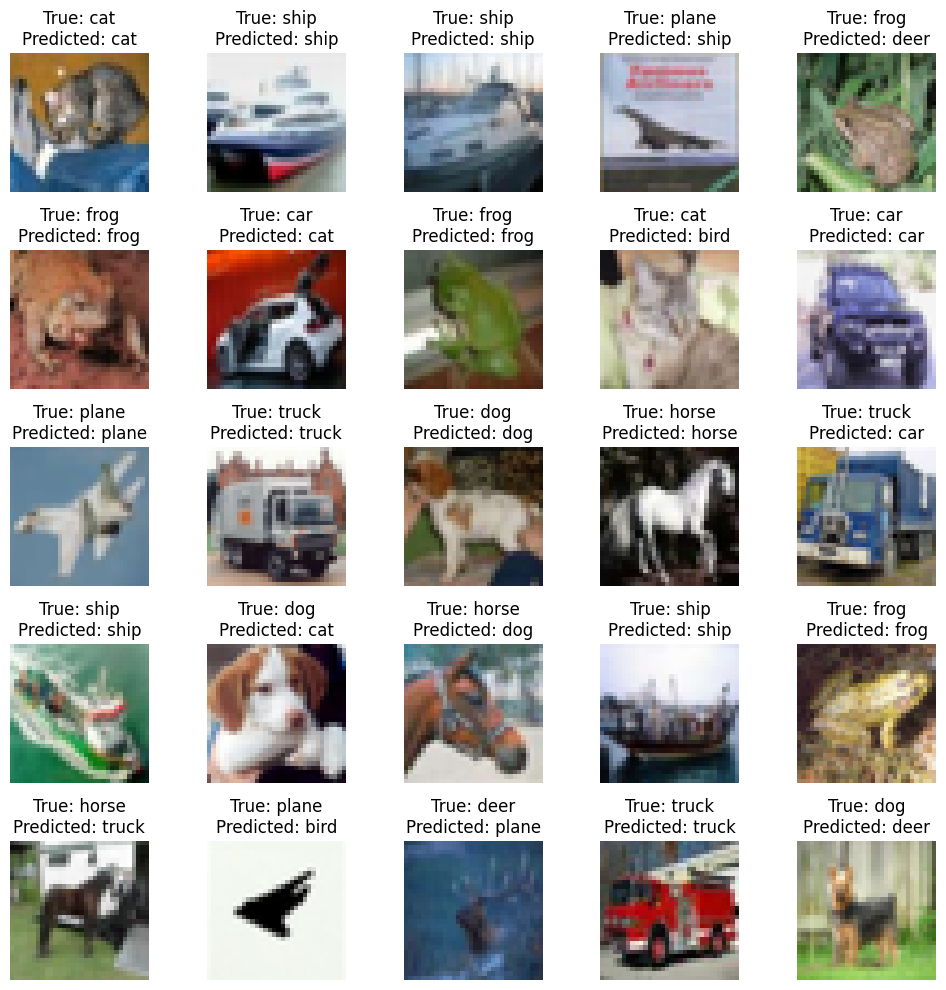

In [18]:
visualize_predictions(model, test_loader, 25)

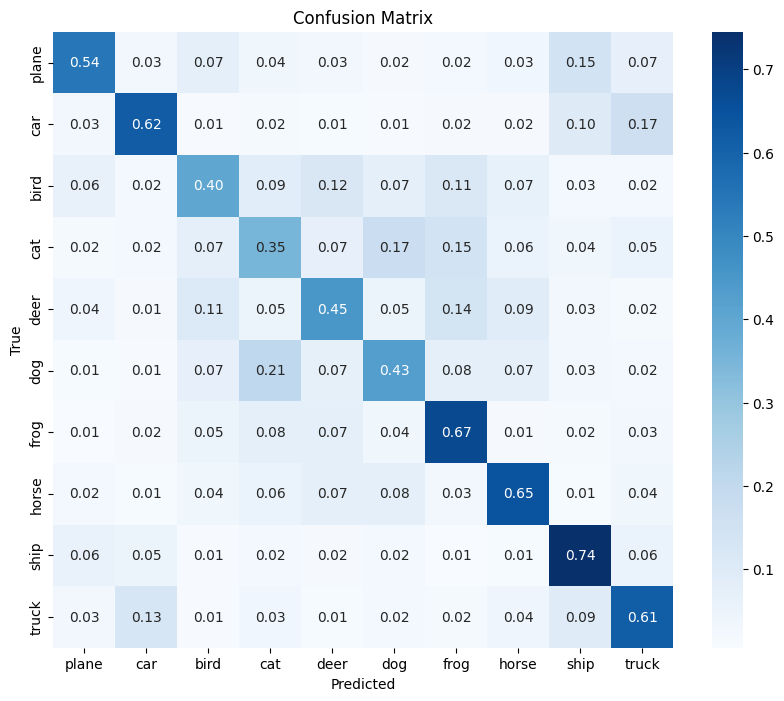

In [19]:
plot_confusion_matrix(model, test_loader)